In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import torch
from torch.nn import DataParallel
from torch.utils.data import DataLoader
from torch.optim import AdamW

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import gc

import sys
sys.path.append("../src")
import FE
import dataset
import models
import util
from config import read_config, update_config
import train_helper
import infer_helper
import loss
import lrfinder
import optim

In [4]:
print(torch.version.cuda)

11.1


In [5]:
import numpy as np

# Config

In [6]:
config = read_config("LSTM4_base_epoch300_ROP_RangerLars")
config.gpu = [0]
config.train_folds = [0]

In [7]:
config = update_config(config)

Using device: cuda
Number of device: 1
Model Output Folder: /home/vincent/Kaggle/GBVPP/output/LSTM4_base_epoch300_ROP_RangerLars/


In [8]:
train, test = dataset.read_data(config)
display(train.shape, test.shape)
display(train.head())
display(test.head())

(6036000, 9)

(4024000, 7)

,id,breath_id,R,C,time_step,u_in,u_out,pressure,fold
0,1,1,20,50,0.000000,0.083334,0,5.837492,0
1,2,1,20,50,0.033652,18.383041,0,5.907794,0
2,3,1,20,50,0.067514,22.509277,0,7.876254,0
3,4,1,20,50,0.101542,22.808823,0,11.742872,0
4,5,1,20,50,0.135756,25.355850,0,12.234987,0


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320955,0


In [9]:
train.dtypes

id            uint32
breath_id     uint32
R             uint32
C             uint32
time_step    float32
u_in         float32
u_out           int8
pressure     float64
fold           int64
dtype: object

# adding features

In [10]:
train = FE.add_features_choice(train, config)
test = FE.add_features_choice(test, config)

In [11]:
feature_cols = [col for col in train.columns if col not in ["id", "breath_id", "fold", "pressure"]]
print(feature_cols)

['time_step', 'u_in', 'u_out', 'step', 'time_delta', 'area', 'u_in_cumsum', 'u_out_diff', 'cross_time', 'cross_u_in', 'u_in_first', 'u_in_last', 'time_end', 'u_in_lag1', 'u_in_lag_back1', 'u_in_lag2', 'u_in_lag_back2', 'u_in_lag3', 'u_in_lag_back3', 'u_in_lag4', 'u_in_lag_back4', 'u_out_lag_back1', 'u_out_lag_back2', 'u_in_diff', 'u_in_diff_2', 'u_in_diff_4', 'ewm_u_in_mean', 'ewm_u_in_std', 'ewm_u_in_corr', 'rolling_10_mean', 'rolling_10_max', 'rolling_10_std', 'expand_mean', 'expand_median', 'expand_std', 'expand_max', 'expand_skew', 'expand_kurt', 'u_in_max', 'u_in_mean', 'u_in_diffmax', 'u_in_diffmean', 'RC_u_in_median_diff', 'RC_u_in_mean_diff', 'R_20', 'R_5', 'R_50', 'C_10', 'C_20', 'C_50', 'R_C_20_10', 'R_C_20_20', 'R_C_20_50', 'R_C_50_10', 'R_C_50_20', 'R_C_50_50', 'R_C_5_10', 'R_C_5_20', 'R_C_5_50']


In [12]:
display(train.head()), display(test.head())

,id,breath_id,time_step,u_in,u_out,pressure,fold,step,time_delta,area,...,C_50,R_C_20_10,R_C_20_20,R_C_20_50,R_C_50_10,R_C_50_20,R_C_50_50,R_C_5_10,R_C_5_20,R_C_5_50
0,1,1,0.000000,0.083334,0,5.837492,0,0,0.000000,0.000000,...,1,0,0,1,0,0,0,0,0,0
1,2,1,0.033652,18.383041,0,5.907794,0,1,0.033652,0.618632,...,1,0,0,1,0,0,0,0,0,0
2,3,1,0.067514,22.509277,0,7.876254,0,2,0.033862,1.380843,...,1,0,0,1,0,0,0,0,0,0
3,4,1,0.101542,22.808823,0,11.742872,0,3,0.034028,2.156978,...,1,0,0,1,0,0,0,0,0,0
4,5,1,0.135756,25.355850,0,12.234987,0,4,0.034213,3.024485,...,1,0,0,1,0,0,0,0,0,0


,id,breath_id,time_step,u_in,u_out,step,time_delta,area,u_in_cumsum,u_out_diff,...,C_50,R_C_20_10,R_C_20_20,R_C_20_50,R_C_50_10,R_C_50_20,R_C_50_50,R_C_5_10,R_C_5_20,R_C_5_50
0,1,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,1,0
1,2,0,0.031904,7.515046,0,1,0.031904,0.239758,7.515046,0.0,...,0,0,0,0,0,0,0,0,1,0
2,3,0,0.063827,14.651675,0,2,0.031924,0.707491,22.166721,0.0,...,0,0,0,0,0,0,0,0,1,0
3,4,0,0.095751,21.230610,0,3,0.031924,1.385252,43.397331,0.0,...,0,0,0,0,0,0,0,0,1,0
4,5,0,0.127644,26.320955,0,4,0.031893,2.224694,69.718285,0.0,...,0,0,0,0,0,0,0,0,1,0


(None, None)

# Learning Rate Finder

In [13]:
config.use_lr_finder = True

In [14]:
if config.use_lr_finder:
    # data
    rs = RobustScaler(quantile_range=(config.low_q, config.high_q), unit_variance=config.unit_var)
    X_train = rs.fit_transform(train[feature_cols])
    X_train = X_train.reshape(-1, 80, len(feature_cols))
    y_train = train['pressure'].values.reshape(-1, 80)
    w_train = (1 - train['u_out']).values.reshape(-1, 80)
    train_dt = dataset.LR_VPP(X_train, y_train, w_train, config)
    train_loader = DataLoader(train_dt,
                              batch_size=config.batch_size,
                              shuffle=True,
                              num_workers=config.num_workers, pin_memory=True, drop_last=False)

In [15]:
if config.use_lr_finder:
    # model
    model = models.get_model(len(feature_cols),config)
    model.to(config.device)
    if len(config.gpu) > 1:
        model = DataParallel(model)
    optimizer = optim.get_optimizer(model, config)
    criterion = loss.get_loss(config)

/home/vincent/Kaggle/GBVPP/notebook/../src/optim.py:545: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


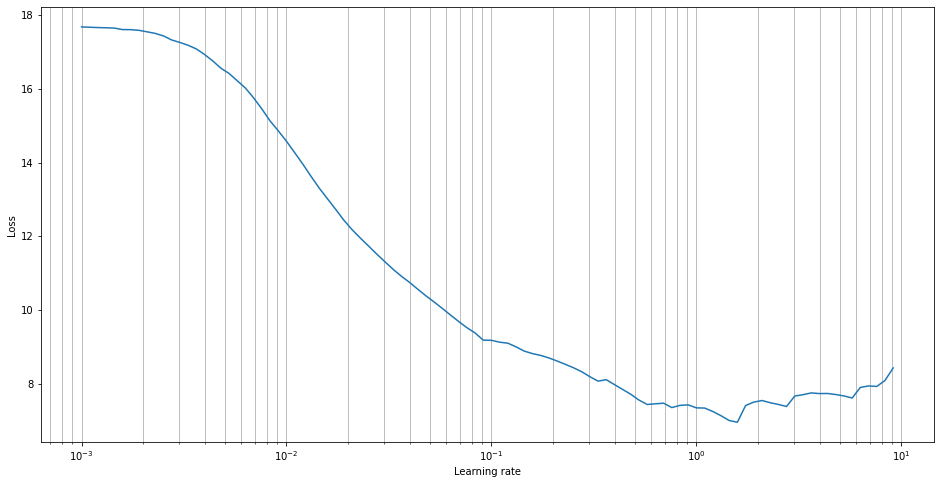

In [16]:
if config.use_lr_finder:
    lr_finder = lrfinder.LRFinder(model, optimizer, criterion, config.device)
    lrs, losses = lr_finder.range_test(train_loader, end_lr=10, num_iter=100, smooth_f=0.05, diverge_th=5)    
    lrfinder.plot_lr_finder(lrs, losses)

In [17]:
if config.use_lr_finder:
    del model, optimizer, criterion, train_dt, train_loader, lr_finder
    gc.collect()
    torch.cuda.empty_cache() 

# Training

In [ ]:
train_helper.training_loop(train.copy(), config)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Fold:  0
Use scale to fit train and scale valid
Prepare train valid
(4841200, 52) (1194800, 52)
training data samples, val data samples:  (60515, 80, 48) (14935, 80, 48)
Transform number into class
Transform number into class
Model Size: 5804660
Epoch:  0
Transform class into number
loss:  4.5432, val_loss 3.8590, val_score 1.6776, best_val_score 1.6776, lr 0.00100 --- use 28.108s
Epoch:  1
Transform class into number
loss:  3.6699, val_loss 3.5367, val_score 1.3239, best_val_score 1.3239, lr 0.00100 --- use 25.427s
Epoch:  2
Transform class into number
loss:  3.4751, val_loss 3.4231, val_score 1.7276, best_val_score 1.3239, lr 0.00100 --- use 24.368s
Epoch:  3
Transform class into number
loss:  3.3644, val_loss 3.3279, val_score 0.9268, best_val_score 0.9268, lr 0.00100 --- use 24.448s
Epoch:  4
Transform class into number
loss:  3.2802, val_loss 3.2340, val_score 0.8834, best_val_score 0.8834, lr 0.00100 --- use 24.591s
Epoch:  5
Transform class into number
loss:  3.2081, val_loss 3.

loss:  2.3046, val_loss 2.5029, val_score 0.2730, best_val_score 0.2614, lr 0.00100 --- use 24.769s
Epoch:  58
Transform class into number
loss:  2.3035, val_loss 2.4755, val_score 0.2544, best_val_score 0.2544, lr 0.00100 --- use 24.806s
Epoch:  59
Transform class into number
loss:  2.3021, val_loss 2.4979, val_score 0.2612, best_val_score 0.2544, lr 0.00100 --- use 24.383s
Epoch:  60
Transform class into number
loss:  2.2834, val_loss 2.4696, val_score 0.2493, best_val_score 0.2493, lr 0.00100 --- use 24.552s
Epoch:  61
Transform class into number
loss:  2.2712, val_loss 2.4788, val_score 0.2550, best_val_score 0.2493, lr 0.00100 --- use 24.413s
Epoch:  62
Transform class into number
loss:  2.2680, val_loss 2.4999, val_score 0.2729, best_val_score 0.2493, lr 0.00100 --- use 24.529s
Epoch:  63
Transform class into number
loss:  2.2725, val_loss 2.5082, val_score 0.2611, best_val_score 0.2493, lr 0.00100 --- use 24.393s
Epoch:  64
Transform class into number
loss:  2.2542, val_loss 2.4

In [ ]:
gc.collect()
torch.cuda.empty_cache()

# Inference

In [ ]:
test_avg = infer_helper.get_test_avg(train.query("fold==0").copy(), config, 20)

In [ ]:
test_avg

In [ ]:
train.query("fold==0")['pressure']

In [ ]:
test_avg["pressure"].hist(bins=100)
plt.show()

In [ ]:
train["pressure"].hist(bins=100)
plt.show()